# Plot NSE CDFs

Notebook 5/X

This just so happens to be the _second_ time I've written this notebook because _GitHub_ ate the first one (it definitely cannot be attributed to me in any way and I absolutely cannot think of (minimum) three reasons why it even _could_ be my fault).

So far we have 1) created climate nonstationarity configuration files, 2) created sister job scripts for SAC-SMA, sent off those models, 3) ensembled and analyzed the results, and 4) performed more in-depth analyses between two models.

Finally, we can plot metric CDFs for ALL of our experiments.

### Import Libraries

In [1]:
# standard modules
import os
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from pathlib import Path, PosixPath
from matplotlib.transforms import offset_copy

##### Notebook Configuration

Here we can define which metric we would like to plot in the CDFs. I will use the Nash-Sutcliffe Efficiency (NSE) Coefficient, which is most commonly used to vizualize hydrological model performance, but any metrics calculated in notebook 3/X can be used.

In [2]:
#########################################################################################

#Define metric CDF to plot
metric = 'nse'

#Define if plots are inline or interactive
interactive_plots = False

#########################################################################################

##### Paths

In [3]:
#########################################################################################

#Path to working directory (current directory)
working_dir = Path(os.getcwd())

#Path to notebook_env_saves directory (.../notebook_env_saves)
env_saves_dir = working_dir / 'notebook_env_saves'

#########################################################################################

**You should not have to edit anything below this cell.**

The cell below orients the notebook based on the parameters specifed above.

In [4]:
#Make plots interactive or inline according to value of interactive_plots variable
if interactive_plots:
    %matplotlib notebook
    %matplotlib notebook
else:
    %matplotlib inline

### Load Source Data

In [5]:
#Retreive list of cdfs files avaliable in env_saves_dir
cdfs_list = [x for x in os.listdir(env_saves_dir) if x.startswith('cdf')]

In [6]:
#Initiate dictionary to store all loaded cdfs files
cdfs = {}

#For every file in cdfs_list...
for cdf in cdfs_list:
    
    #Define path to the file
    path = env_saves_dir / cdf
    
    #Get name from file name
    name = cdf.split('cdfs_')[1].split('.')[0]
    
    #Open path...
    with open(path,'rb') as f:
        
        #...and load
        cdfs[name] = pkl.load(f)

### Plot CDFs

 Extreme vs. Random Train/Test Splits

First we will to create a 2x2 grid of CDF plots for a defined metric for the possible model/forcing pairs. In this case, NeuralHydrology/SAC-SMA and Daymet/NLDAS. Note that I only plot static NeuralHydrology experiments for this figure and that, although SAC-SMA is saved as 'dynamic' for structure consistency, SAC-SMA cannot accept external static or dynamic values.

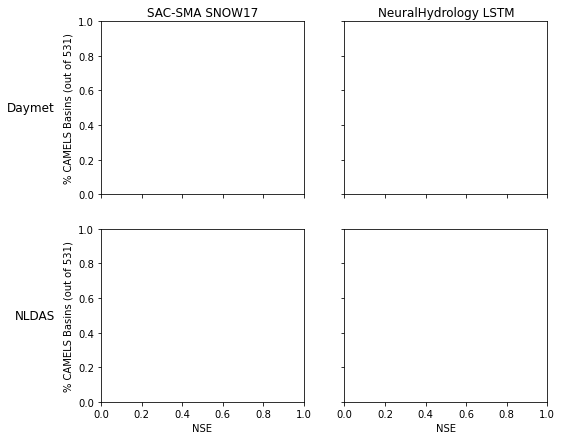

In [7]:
#Define columns and rows of plots
cols = ['SAC-SMA SNOW17','NeuralHydrology LSTM']
rows = ['Daymet','NLDAS']

#Create list(s) of subplot coordinates
#Row
ns = [0,0,1,1]
#Column
ms = [0,1,0,1]

#List of models (one for each plot)
models = ['sacsma','nh','sacsma','nh']
#List of forcings (one for each plot)
forcings = ['daymet','daymet','nldas_extended','nldas_extended']

#List train/test split types
exp_types = ['extreme','random']
year = ['all']
    
#Create a 2x2 grid of plots (one plot for each model/forcing pair)
fig, axs = plt.subplots(2,2,figsize = (8,7))
#Set subplot labels (NOTICE THAT NSE IS HARDCODED HERE)
plt.setp(axs.flat, xlabel='NSE', ylabel='% CAMELS Basins (out of 531)')
#Define a pad distance between texts
pad = 5 # in points

#For every column...
for ax, col in zip(axs[0], cols):
    
    #Create an annotation to signify which model
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

#For every row...
for ax, row in zip(axs[:,0], rows):
    
    #Create an annotation to signify which forcing
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

#For a given position (n,m) where a model/forcing pair is to be plot...
for n,m,model,forcing in zip(ns,ms,models,forcings):

    #Default input to static (as we only want to plot static)
    inp = 'static'

    #But if the model is sacsma...
    if model == 'sacsma':
        
        #Set input to dynamic
        inp = 'dynamic'

    #For every train/test split type...
    for exp_type in exp_types:

        #Define a name with the current iterators
        name = f'{model}_{inp}_{exp_type}_{forcing}_{year}'

        #And if that name is in the cdfs dictionary...
        if name in cdfs.keys():

            #Go into that dictionary and retrieve experiment names
            experiments = cdfs[name].keys()

            #Set r to 0 (keeps count of how many random cdf lines we plot...
            #...so we don't have 500 "random"s on the legend)
            r = 0

            #For every experiment...
            for experiment in experiments:

                #Retrieve x and y values from cdfs dictionary
                x = cdfs[name][experiment][metric]['x']
                y = cdfs[name][experiment][metric]['y']

                #Default color, transparency, line width, and line type
                c = 'r'
                alpha = 1
                lw = 1.2
                l = ':'

                #If we are plotting p_mean...
                if 'p' in experiment:

                    #Make the line blue
                    c = 'blue'

                #If it was a 'low' experiment...
                if 'low' in experiment:

                    #Decrease the alpha to make it a lighter color
                    alpha = 0.4

                #If sacsma model...
                if 'sacsma' in name:

                    #Make the line dash-dot and line width 1
                    l = '-.'
                    lw = 1

                #If random experiment...
                if 'random' in name:

                    #Add 1 to r variable, make line grey, line width 1, and decrease alpha
                    r = r + 1
                    c = 'grey'
                    lw = 1
                    alpha = 0.6

                    #If sacsma model...
                    if 'sacsma' in name:

                        #Decrease line width
                        lw = 0.7

                    #If are isn't 1, then set label to None
                    if r != 1:
                        label = None

                #Plot x,y with the defined line type/color,width, alpha, and label 
                axs[n,m].plot(x,y,l,c=c,alpha=alpha,lw=lw) #add label
                
                #Set axes limits
                axs[n,m].set_xlim(left=-1, right=1)
                axs[n,m].set_ylim(bottom=0, top=1)

                #Create main figure title
                fig.suptitle(f'Extreme vs. Random Train/Test Splits', fontsize=20)

    #Only show labels for outter plots
    for ax in axs.flat:
        ax.label_outer()   

#Show plot
plt.show()

In [8]:
#If plot interactive, must explicitly close
plt.close()

##### All Years vs. Only NWM Years

Next, we will to create a 2x2 grid of CDF plots for a defined metric for the possible forcing/year pairs. In this case, Daymet/NLDAS and all/nwm.

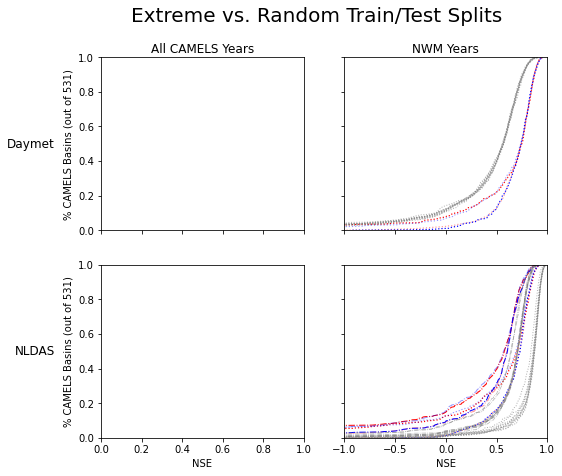

In [9]:
#Define columns and rows of plots
cols = ['All CAMELS Years','NWM Years']
rows = ['Daymet','NLDAS']

#Create list(s) of subplot coordinates
#Row
ns = [0,0,1,1]
#Column
ms = [0,1,0,1]

#List of forcings (one for each plot)
forcings = ['daymet','daymet','nldas_extended','nldas_extended']
#List of years (one for each plot)
years = ['all','nwm','all','nwm']

#List of models
models = ['nh','sacsma']
#List of experiment types
exp_types = ['extreme','random']

    
#Create a 2x2 grid of plots (one plot for each forcing/year pair)
fig, axs = plt.subplots(2,2,figsize = (8,7))
#Set subplot labels (NOTICE THAT NSE IS HARDCODED HERE)
plt.setp(axs.flat, xlabel='NSE', ylabel='% CAMELS Basins (out of 531)')
#Define a pad distance between texts
pad = 5 # in points

#For every column...
for ax, col in zip(axs[0], cols):
    
    #Create an annotation to signify which years
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

#For every row...
for ax, row in zip(axs[:,0], rows):
    
    #Create an annotation to signify which forcing
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

#For a given position (n,m) where a forcing/year pair is to be plot...
for n,m,forcing,year in zip(ns,ms,forcings,years):
    #For each model...
    for model in models:
        #And for each experiment type...
        for exp_type in exp_types:
        
            #Default input type to static...
            inp = 'static'

            #Unless it's a sacsma model
            if model == 'sacsma':
                
                #Then it should be dynamic
                inp = 'dynamic'
            
            #Define a name with the current iterators
            name = f'{model}_{inp}_{exp_type}_{forcing}_{year}'
            
            #And if that name is in the cdfs dictionary...
            if name in cdfs.keys():

                #Go into that dictionary and retrieve experiment names
                experiments = cdfs[name].keys()
                
                #Set r to 0 (keeps count of how many random cdf lines we plot...
                #...so we don't have 500 "random"s on the legend)
                r = 0

                #For every experiment...
                for experiment in experiments:

                    #Retrieve x and y values from cdfs dictionary
                    x = cdfs[name][experiment][metric]['x']
                    y = cdfs[name][experiment][metric]['y']

                    #Default color, transparency, line width, and line type
                    c = 'r'
                    alpha = 1
                    lw = 1.2
                    l = ':'

                    #If we are plotting p_mean...
                    if 'p' in experiment:
                        
                        #Make the line blue
                        c = 'blue'

                    #If it was a 'low' experiment...
                    if 'low' in experiment:

                        #Decrease the alpha to make it a lighter color
                        alpha = 0.4

                    #If sacsma model...
                    if 'sacsma' in name:

                        #Make the line dash-dot and line width 1
                        l = '-.'
                        lw = 1

                    #If random experiment...
                    if 'random' in name:

                        #Add 1 to r variable, make line grey, line width 1, and decrease alpha
                        r = r + 1
                        c = 'grey'
                        lw = 1
                        alpha = 0.6
                        
                        #If sacsma model...
                        if 'sacsma' in name:

                            #Decrease line width
                            lw = 0.7

                        #If are isn't 1, then set label to None
                        if r != 1:
                            label = None

                    #Plot x,y with the defined line type/color,width, alpha, and label 
                    axs[n,m].plot(x,y,l,c=c,alpha=alpha,lw=lw) #add label
                    
                    #Set axes limits
                    axs[n,m].set_xlim(left=-1, right=1)
                    axs[n,m].set_ylim(bottom=0, top=1)

                    #Create main figure title
                    fig.suptitle(f'Extreme vs. Random Train/Test Splits', fontsize=20)

        #Only show labels for outside plots
        for ax in axs.flat:
            ax.label_outer()   

#Show plot
plt.show()

In [10]:
#If plot interactive, must explicitly close
plt.close()

##### Static Attributes vs. Dynamic Climate Index Inputs

Next, we will to create a 2x2 grid of CDF plots for a defined metric for the possible forcing/year pairs. In this case, Daymet/NLDAS and all/nwm. This time, however, instead of plotting SAC-SMA we are only plotting NeuralHydrology. Also, instead of only plotting static experiments, we plot both static and dynamic.

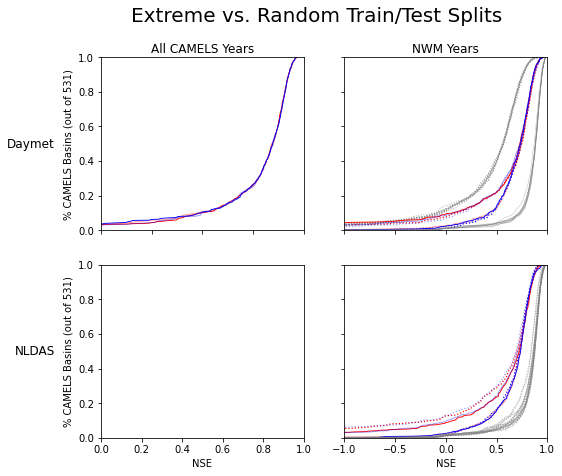

In [11]:
#Define columns and rows of plots
cols = ['All CAMELS Years','NWM Years']
rows = ['Daymet','NLDAS']

#Create list(s) of subplot coordinates
ns = [0,0,1,1]
ms = [0,1,0,1]

#List of forcings (one for each plot)
forcings = ['daymet','daymet','nldas_extended','nldas_extended']
#List of years (one for each plot)
years = ['all','nwm','all','nwm']

#List of experiment types
exp_types = ['extreme','random']
#List of inputs
inputs = ['static','dynamic']

#Only plot neuralhydrology models
model = 'nh'

#Create a 2x2 grid of plots (one plot for each forcing/year pair)
fig, axs = plt.subplots(2,2,figsize = (8,7))

#Set subplot labels (NOTICE THAT NSE IS HARDCODED HERE)
plt.setp(axs.flat, xlabel='NSE', ylabel='% CAMELS Basins (out of 531)')
#Define a pad distance between texts
pad = 5 # in points

#For every column...
for ax, col in zip(axs[0], cols):
        
    #Create an annotation to signify which years
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

#For every row...
for ax, row in zip(axs[:,0], rows):
    
    #Create an annotation to signify which forcing
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

#For a given position (n,m) where a model/forcing pair is to be plot...
for n,m,forcing,year in zip(ns,ms,forcings,years):

    #For each input type...
    for inp in inputs:
        
        #For each experiment type...
        for exp_type in exp_types:
        
            #Define a name with the current iterators
            name = f'{model}_{inp}_{exp_type}_{forcing}_{year}'

            #And if that name is in the cdfs dictionary...
            if name in cdfs.keys():
                
                #Go into that dictionary and retrieve experiment names
                experiments = cdfs[name].keys()

                #Set r to 0 (keeps count of how many random cdf lines we plot...
                #...so we don't have 500 "random"s on the legend)
                r = 0

                #For every experiment...
                for experiment in experiments:

                    #Retrieve x and y values from cdfs dictionary
                    x = cdfs[name][experiment]['nse']['x']
                    y = cdfs[name][experiment]['nse']['y']

                    #Default color, transparency, line width, and line type
                    c = 'r'
                    alpha = 1
                    lw = 1.2
                    l = ':'

                    #If dynamic model...
                    if 'dynamic' in name:

                        #Line type is solid
                        l = '-'
                        lw = 0.9

                    #If p_mean...
                    if 'p' in experiment:

                        #Plot blue line
                        c = 'blue'

                    #If 'low' experiment...
                    if 'low' in experiment:

                        #Decrease alpha to make lighter color
                        alpha = 0.4

                    #If a random experiment...
                    if 'random' in name:

                        #Add count to r variable and make line grey
                        r = r + 1
                        c = 'grey'
                        lw = 1
                        alpha = 0.6

                        #If dynamic, make line solid
                        if 'dynamic' in name:
                            lw = 0.5
                            alpha = 0.5

                        #If are isn't 1, then set label to None
                        if r != 1:
                            label = None

                    #Plot x,y with the defined line type/color,width, alpha, and label 
                    axs[n,m].plot(x,y,l,c=c,alpha=alpha,lw=lw) #add label
                    
                    #Set axes limits
                    axs[n,m].set_xlim(left=-1, right=1)
                    axs[n,m].set_ylim(bottom=0, top=1)

                    #Create main figure title
                    fig.suptitle(f'Extreme vs. Random Train/Test Splits', fontsize=20)

        #Only show labels for outside plots
        for ax in axs.flat:
            ax.label_outer()   

#Show plot
plt.show()

In [12]:
#If plot interactive, must explicitly close
plt.close()